In [139]:
import sqlite3
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [140]:
db_path = 'jobs.db'
conn = sqlite3.connect(db_path)

query = """
SELECT
    title,
    salary,
    company,
    location,
    welcomed_skill,
    employment_type
FROM jobs
"""

# SQLを実行し、データを取得
df = pd.read_sql_query(query, conn)
conn.close()

# 取得したデータの先頭5行を確認
df.head()

,title,salary,company,location,welcomed_skill,employment_type
0,【未経験歓迎&フルリモ可】総合職（事務・マーケ・広報・営業・人事等）年収アップ確約！年休13...,年収：250～750万円,ＧＭＯコネクト株式会社【東証プライム上場 GMOインターネットグループ】,〈東京本社〉東京都渋谷区桜丘町26番1号セルリアンタワー7階（最寄駅：渋谷駅徒歩5分）※フル...,＼1つでも当てはまる方はご応募ください！／・人と話すのが好き：顧客や同僚とスムーズにコミュニ...,正社員\n /\n ...
1,動画編集・Webデザイン｜未経験歓迎◆Youtubeデザイン研修◆フルリモート◆月給30万◆...,年収：350～1000万円,株式会社FEDELTA,＼＼リモートワークも多数／／★全国で採用中★【転勤なし／希望を考慮】一都三県、群馬、関西、九...,＃WebやITに興味がある方＃SNSが好きな方＃動画を見る方が好きな方＃ものづくりが好きな方...,正社員\n /\n ...
2,動画編集*投稿サイトの動画制作スタッフ*残業なし*完全週休2日制*髪型・服装・ネイル自由*リ...,年収：350～600万円,株式会社Ｄｕｎｋ,■勤務地○渋谷 ○池袋 ○新宿○横浜市西区 ○大阪市北区梅田※あなたの経験やスキルに応じて研...,動画編集スキル（Premiere Pro）,正社員\n /\n ...
3,ITオフィスサポート*未経験OK♪ *年間休日130日*リモート8割*残業月3.6h*服装・...,年収：300～1100万円,株式会社トライ,東京・神奈川・埼玉・千葉・大阪・愛知・福岡の各案件先勤務となります。◎勤務地は希望を考慮して...,◎Excel、Wordを使用できる方◎VBAその他ツール作成できる言語知識◎PM/PMO 経...,正社員\n /\n ...
4,オープンポジション,None,富士フイルム株式会社【ポジションマッチ登録】,東京、神奈川、埼玉、静岡など（事業所一覧：https://www.fujifilm.com/...,None,正社員


In [181]:
# 年収のデータを確認
def convert_salary_to_numeric(salary_str):
    
    try:
        clean_str = salary_str.replace('年収：', '').replace('万円', '')

        # '～' が含まれている場合
        if '～' in clean_str:
            min_val, max_val = clean_str.split('～')
            min_val = float(min_val)
            max_val = float(max_val)
            return (min_val + max_val) / 2
        else:
            # '～' がない場合、単一数値だけの場合 (例：年収：300万円)
            return float(clean_str)
    except:
        # 変換できない場合などは np.nan を返す
        return np.nan

# 実際のカラムに適用
df['salary_numeric'] = df['salary'].astype(str).apply(convert_salary_to_numeric)

年収の平均値: 601.7628205128206
年収の中央値: 562.5


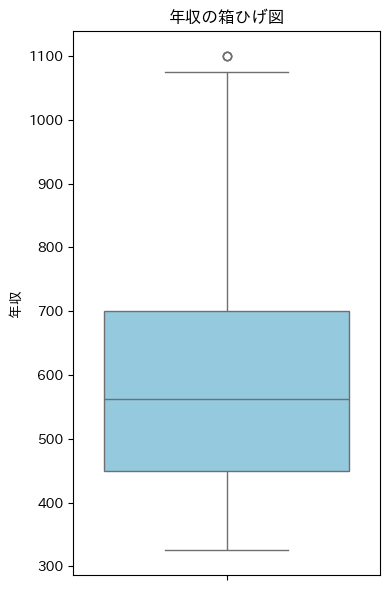

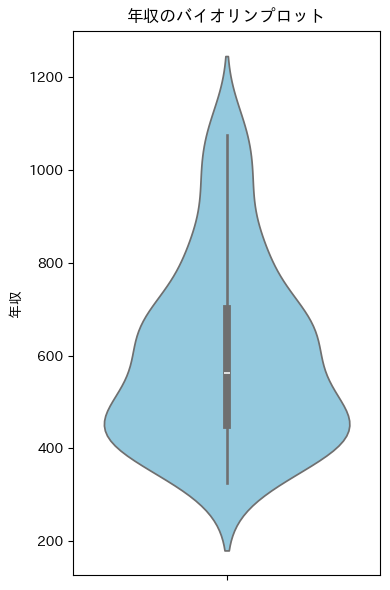

In [192]:
# 年収カラム（salary）の平均と中央値を計算
mean_salary = df['salary_numeric'].mean()
median_salary = df['salary_numeric'].median()

print("年収の平均値:", mean_salary)
print("年収の中央値:", median_salary)

# 年収の箱ひげ図を描画
plt.figure(figsize=(4, 6))
sns.boxplot(y=df['salary_numeric'], color='skyblue')
plt.title('年収の箱ひげ図')
plt.ylabel('年収')
plt.tight_layout()
plt.show()

# 年収のバイオリンプロットを描画
plt.figure(figsize=(4, 6))
sns.violinplot(y=df['salary_numeric'], color='skyblue')
plt.title('年収のバイオリンプロット')
plt.ylabel('年収')
plt.tight_layout()
plt.show()

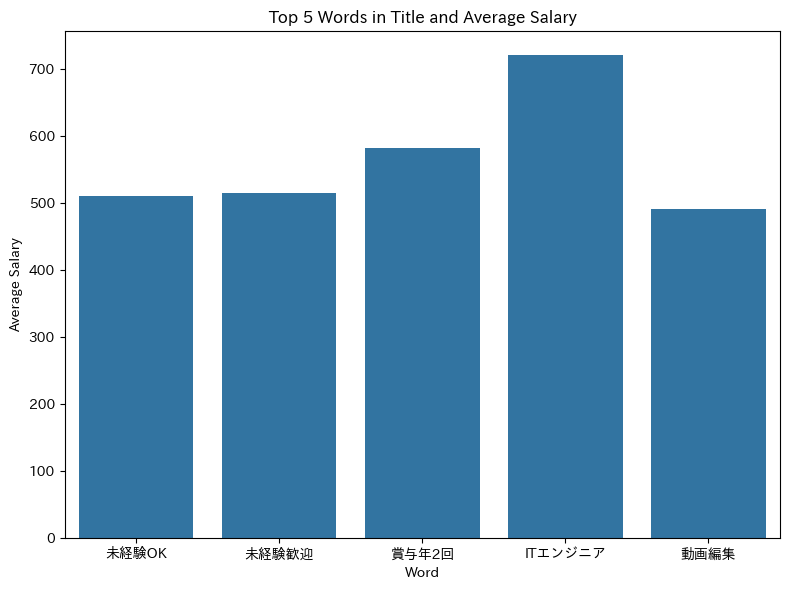

In [ ]:
pattern = re.compile(r'[ぁ-んァ-ン一-龥ーA-Za-z0-9]+')

word_list = []
for t in df['title']:
    if t is None:
        continue
    # 正規表現でマッチした文字列を抽出
    words = pattern.findall(str(t))
    word_list.extend(words)

# 単語の出現回数をカウント
counter = Counter(word_list)
top5_words = [w[0] for w in counter.most_common(5)]

# タイトルに各単語が含まれていれば1、なければ0 のフラグ列を付与
for word in top5_words:
    df[f'has_{word}'] = df['title'].astype(str).apply(lambda x: 1 if word in x else 0)

# グラフ表示のために各単語が含まれるデータの平均年収を計算
avg_salaries = []
for word in top5_words:
    avg_salary = df[df[f'has_{word}'] == 1]['salary_numeric'].mean()
    avg_salaries.append(avg_salary)

# グラフ表示
plt.figure(figsize=(8, 6))
sns.barplot(x=top5_words, y=avg_salaries)
plt.title('Top 5 Words in Title and Average Salary')
plt.xlabel('Word')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()

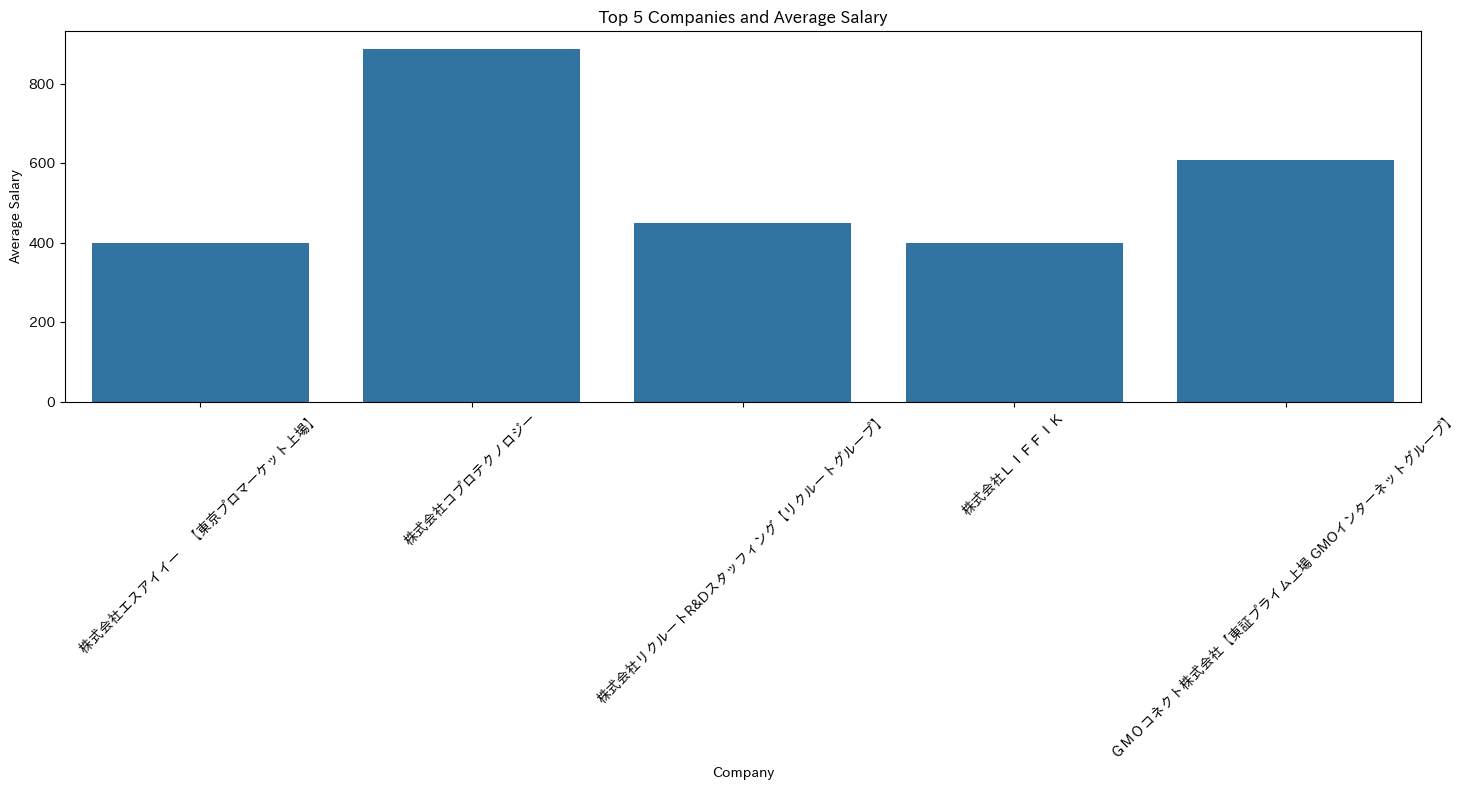

In [ ]:
# salary_numeric が NaN の行を除外
df = df.dropna(subset=['salary_numeric'])

# 上位5社を取り出す
company_counts = df['company'].value_counts()
top5_companies = company_counts.index[:5]

# 上位5社の平均年収を計算
company_salary = df[df['company'].isin(top5_companies)].groupby('company')['salary_numeric'].mean()

# グラフ表示
plt.figure(figsize=(15, 8))
sns.barplot(x=company_salary.index, y=company_salary.values)
plt.title('Top 5 Companies and Average Salary')
plt.xlabel('Company')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Index(['北海道', '東京都', 'リモート', '埼玉県', '宮城県'], dtype='object', name='location_extracted')


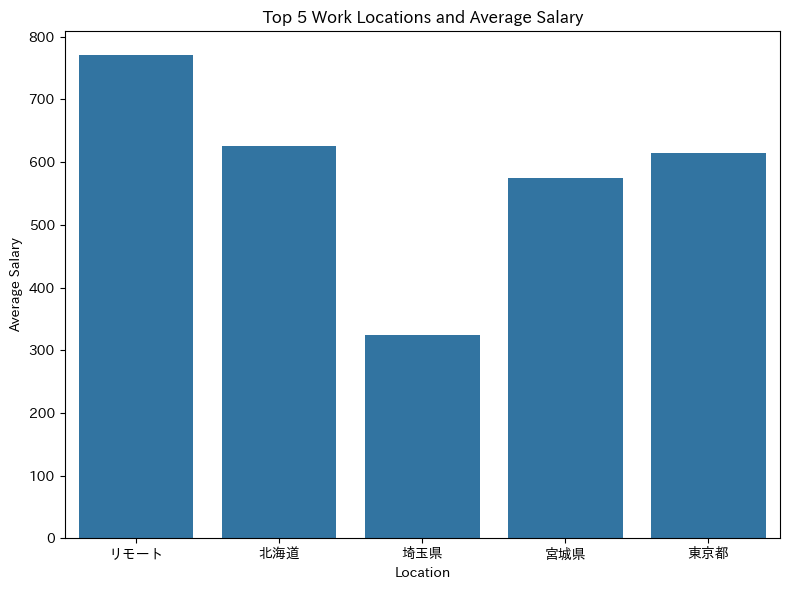

In [ ]:
# NaNを落とす
df = df.dropna(subset=['location'])

# 47都道府県 + 'リモート'
prefectures_and_remote = {
    "北海道","青森県","岩手県","宮城県","秋田県","山形県","福島県",
    "茨城県","栃木県","群馬県","埼玉県","千葉県","東京都","神奈川県",
    "新潟県","富山県","石川県","福井県","山梨県","長野県","岐阜県",
    "静岡県","愛知県","三重県","滋賀県","京都府","大阪府","兵庫県",
    "奈良県","和歌山県","鳥取県","島根県","岡山県","広島県","山口県",
    "徳島県","香川県","愛媛県","高知県","福岡県","佐賀県","長崎県",
    "熊本県","大分県","宮崎県","鹿児島県","沖縄県",
    # 特別にリモート
    "リモート"
}

# 抽出用のパターン。ひらがな、カタカナ、漢字、英数など
pattern = re.compile(r'[ぁ-んァ-ン一-龥ーA-Za-z0-9]+')

# 47都道府県 or 'リモート' を抽出する関数
def extract_prefecture_or_remote(text):

    words = pattern.findall(str(text))
    filtered_words = [w for w in words if w in prefectures_and_remote]
    if len(filtered_words) > 0:
        return filtered_words[0]
    else:
        return None

# location から location_extracted 列を作成
df['location_extracted'] = df['location'].apply(extract_prefecture_or_remote)

# location_extracted 列の出現頻度を数える
location_counts = df['location_extracted'].value_counts()

# 上位5件の勤務地
top5_locations = location_counts.index[:5]

# 上位5件に該当する行だけでグループ化して平均給与
location_salary = df[df['location_extracted'].isin(top5_locations)] \
                    .groupby('location_extracted')['salary_numeric'].mean()

# グラフ表示
plt.figure(figsize=(8, 6))
sns.barplot(x=location_salary.index, y=location_salary.values)
plt.title('Top 5 Work Locations and Average Salary')
plt.xlabel('Location')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()


Top 5 words: ['動画編集スキル', 'premiere_pro', '経験', '開発', 'aws']


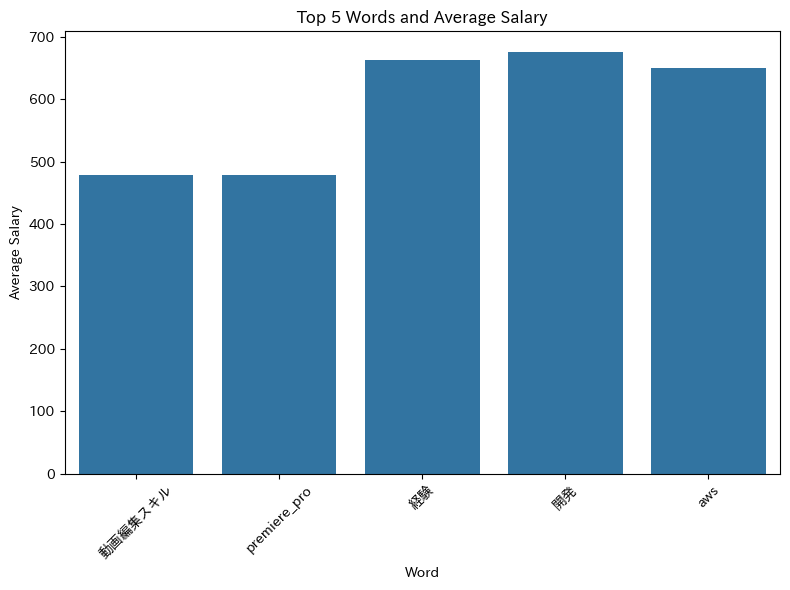

In [187]:
# 欠損値を空文字に置換
df['welcomed_skill'] = df['welcomed_skill'].fillna('').astype(str).str.lower()

# スペースで区切られた文字列をリストに変換
df['welcomed_skill'] = df['welcomed_skill'].str.replace('premiere pro', 'premiere_pro')
df['welcomed_skill'] = df['welcomed_skill'].str.replace('after effects', 'after_effects')

# "none" や "nan" をここで空文字に置換、不要ならスキップ
df['welcomed_skill'] = df['welcomed_skill'].str.replace(r'\bnone\b', '', regex=True)
df['welcomed_skill'] = df['welcomed_skill'].str.replace(r'\bnan\b', '', regex=True)

# 正規表現で単語抽出
pattern = re.compile(r'[A-Za-z0-9_ぁ-んァ-ン一-龥ー]+')
all_words = []

for text in df['welcomed_skill']:
    words = pattern.findall(text)
    all_words.extend(words)

# ストップワード定義: 「など」を含める
stopwords = {"など"}

# 空文字やストップワードを除外して all_words 再構築
all_words = [w for w in all_words if w.strip() != '' and w not in stopwords]

# 出現頻度の高い上位5単語を抽出
counter = Counter(all_words)
top5_skills = [w[0] for w in counter.most_common(5)]
print("Top 5 words:", top5_skills)

# skill_list列を作っておく
def custom_tokenize(text):
    words = pattern.findall(text.lower())
    return [w for w in words if w.strip() and w not in stopwords]

df['skill_list'] = df['welcomed_skill'].apply(custom_tokenize)

# トップ5単語のフラグ列を作成
for skill in top5_skills:
    df[f'has_{skill}'] = df['skill_list'].apply(lambda word_list: 1 if skill in word_list else 0)

# フラグが1の行だけで salary_numeric の平均を計算
skill_avg_salaries = []
for skill in top5_skills:
    mean_salary = df.loc[df[f'has_{skill}'] == 1, 'salary_numeric'].mean()
    skill_avg_salaries.append(mean_salary)

# グラフ表示
plt.figure(figsize=(8, 6))
sns.barplot(x=top5_skills, y=skill_avg_salaries)
plt.title('Top 5 Words and Average Salary')
plt.xlabel('Word')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

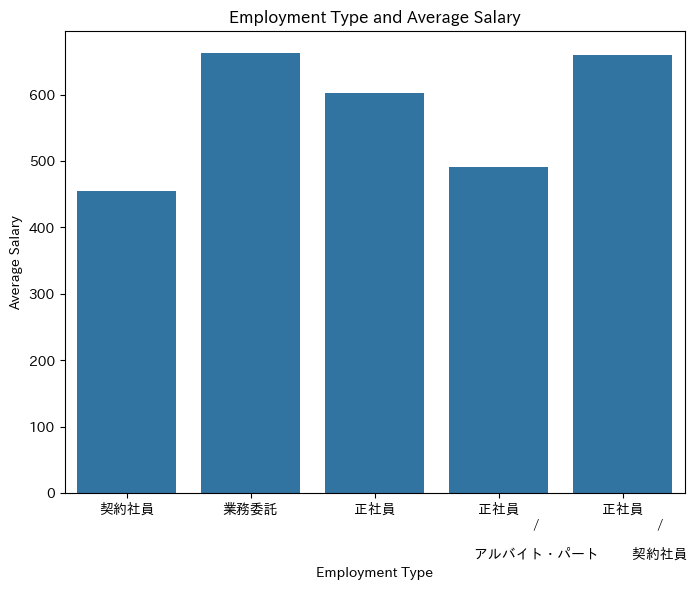

In [188]:
# employment_typeとsalary_numericの平均を計算
employment_salary = df.groupby('employment_type')['salary_numeric'].mean()

# グラフ表示
plt.figure(figsize=(8, 6))
sns.barplot(x=employment_salary.index, y=employment_salary.values)
plt.title('Employment Type and Average Salary')
plt.xlabel('Employment Type')
plt.ylabel('Average Salary')
plt.show()